In [12]:
%load_ext autoreload
%autoreload 2
import numpy as np
from pathlib import Path
import sys
parentDir = Path.cwd().parent
sys.path.insert(0, str(parentDir))
%matplotlib widget
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from utils.features_viz import emg_td_features, features_to_df
from utils.plotting_helpers import plot_feature_by_gesture, plot_feature_mean_sem
from utils.plotting_helpers import plot_feature_heatmap, radar_gesture_signature, pca_scatter

### Load pre-saved epoch data

In [16]:
epoch_data_path = parentDir / "data/processed/ninapro_ex1_win200_ms_step50_ms.npz"
save_figs = True

In [5]:
data = np.load(epoch_data_path)

X = data['X']
y = data['y']
subject_ids = data['subject_ids']
rep_ids = data['rep_ids']
t0 = data['t0']
coverage = data['coverage']
Fs = data['Fs']
n_channels = data['n_channels']
L = data['L']
Ld = data['Ld']
T_ms = data['T_ms']
S_ms = data['S_ms']
gesture_ids_all = data['gesture_ids_all']
exercise_number = data['exercise_number']
include_rest = data['include_rest']
majority_threshold = data['majority_threshold']

In [14]:
emg_features = emg_td_features(X, zc_thresh=0.02, ssc_thresh=0.02, batch_size=20000, flatten=False)
features_df = features_to_df(emg_features, y, subject_ids=subject_ids, rep_ids=rep_ids)

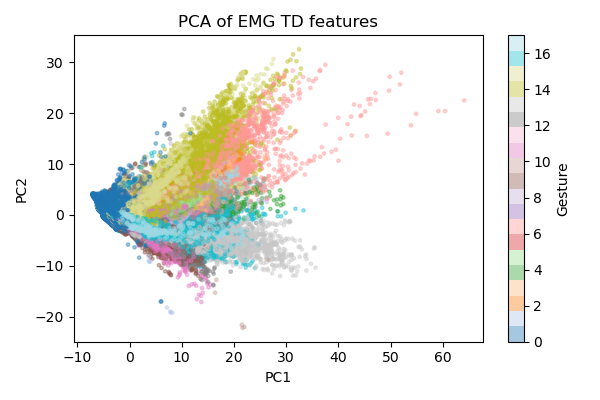

In [19]:
# plot_feature_by_gesture(features_df, feature="RMS", channel=5, figsize=(6, 4))
# plot_feature_mean_sem(features_df, feature="WL", channel=5, figsize=(6, 4))
# plot_feature_heatmap(features_df, feature="SSC", figsize=(6, 4))
# radar_gesture_signature(features_df, channel=5, gestures=[1,6,10,14], figsize=(6, 4))
pca_features = pca_scatter(emg_features, y, figsize=(6, 4))
if save_figs:
    plt.savefig(parentDir / "results/figures/feature_visualizations_PCA.png", dpi=300)